<a href="https://colab.research.google.com/github/ammrit2312/KeyPhrase_BERT/blob/main/KeyPhraseBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Selecting candidate phrases


In [ ]:
import spacy 

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
selected_keyphrases_list=[]

In [ ]:
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)

In [ ]:
pattern1 = [{'POS':'ADJ', 'OP':'*'}, {'IS_PUNCT': True, 'OP':'*'}, {'POS':'NOUN', 'OP':'+'},{'IS_PUNCT': True, 'OP':'*'},{'POS':'ADP'},{'OP':'?'},{'POS':'ADJ'},{'IS_PUNCT': True, 'OP':'*'},{'POS':'NOUN'}]
#pat = [({'POS':'ADJ', 'OP':'*'}, {'IS_PUNCT': True, 'OP':'*'}, {'POS':'NOUN', 'OP':'+'},{'IS_PUNCT': True, 'OP':'*'},{'POS':'ADP'})?]
pattern2 = [{'POS':'ADJ'},{'IS_PUNCT': True, 'OP':'*'},{'POS':'NOUN'}]
pattern3 = [{'ENT_TYPE':'ORG', 'OP':'+'}]
pattern4 = [{'ENT_TYPE':'GPE', 'OP':'+'}]


matcher.add('Noun', None, pattern1, pattern2, pattern3, pattern4)

In [ ]:
f=open('document1.txt')
document=f.read()
doc = nlp(document)

In [ ]:
found_matches = matcher(doc)
phrases = set()
for matcher_id, start, end in found_matches:
  if((start!=end) and (doc[start:end] not in nlp.Defaults.stop_words)):
    phrases.add(str(doc[start:end]))

phrases=list(phrases)



In [ ]:

#removing punctuations
clean = list()
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
for word in phrases:
  x = list(word)
  s=''
  for i in range(len(x)):
    if(x[i] in punc):
      continue
    else:
      s=s+x[i]
  clean.append(s)

#clean = set(clean)
clean = list(clean)
clean.sort()
print(len(clean))

c=0
new= list()
for i in range(len(clean)):
  for j in range(len(clean)):
    if(i==j):
      continue
    if(clean[i] in clean[j]):
      c=1
      break
    c=0
  if(c==0):
    new.append(clean[i])
  c=0

new = set(new)
phrases = list(new)
print(len(phrases))
phrases

56
36


['result of the COVID19 pandemic',
 'pure amateurism',
 'largescale',
 'Greece',
 'international sports',
 'the International Olympic Committee',
 'the Olympic Movement',
 'international fame',
 'terrorist attack',
 '8th century',
 'numerous challenges',
 'different sports',
 'general commercialisation',
 'boycotts',
 'abuse of amateur rules',
 'IOC',
 'several changes',
 'Olympia',
 'Jeux olympiques',
 'Olympic medals',
 'Continental games',
 'Olympic flag',
 'Games',
 'Athens',
 'issue of corporate sponsorship',
 '4th century',
 'Olympic programme',
 'international sporting',
 'acceptance of professional athletes',
 'limited participation',
 'foremost sports',
 'thirdplace',
 'National Olympic Committees',
 'technological advancements',
 '21st centuries',
 'Olympic rituals']

In [ ]:
!pip install transformers

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True,)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

# 2.Document embedding

In [ ]:
sentences= document.split('. ')
#here we tokenize each sentence and convert to ids
#finding maximum length of a sentence (for padding purposes, because bert requires this)
max_len = 0
# For every sentence...
for sentence in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    sentence_id = tokenizer.encode(sentence, add_special_tokens=True)
    # Update the maximum sentence length.
    max_len = max(max_len, len(sentence_id))
#adding 10 extra to max_len just in case
max_len=max_len+10

In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs.
# input ids is a 2d list, each element is a list(that represents a sentence which is tokenised and converted to the ids)
#attention masks is also a 2d list each element is a list(that represents whether each element of the tokenised list is a padded element or not)
input_ids = []
attention_masks = []
# For every phrase...
for sentence in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the phrase.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the phrase to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sentence,                      # phrase to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = 23 ,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # Add the encoded phrase to the list.    
    input_ids.append(encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
#this is where we call the model and pass the encoded tokens of each sentence
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers.
hidden_states=[]
with torch.no_grad():
    for i in range(len(input_ids)):
      outputs = model(input_ids[i],attention_mask=attention_masks[i])
      hidden_states.append(outputs[2])

print(len(hidden_states[0]))

13


In [ ]:
#here we calculate sentence and document embeddings
# `hidden_states` has shape [no of sentences x 13 x 1 x max_len x 768]
sentence_embeddings=[]
# `token_vecs` is a tensor with shape [22 x 768]
for i in range(len(hidden_states)):
  token_vecs = hidden_states[i][-2][0]#we take the embeddings from the second last layer as it has the best balance in terms of context
  # Calculate the average of all token vectors.
  sentence_embedding = torch.mean(token_vecs, dim=0)
  sentence_embeddings.append(sentence_embedding)

sentence_embeddings = torch.stack(sentence_embeddings,dim=0)
document_embedding=torch.mean(sentence_embeddings, dim=0)

# 3.phrase embedding

In [ ]:
#finding maximum length of a phrase (for padding purposes, because bert requires this)
max_len = 0

for phrase in phrases:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    ids = tokenizer.encode(phrase, add_special_tokens=True)
    # Update the maximum phrase length.
    max_len = max(max_len, len(ids))
    
#adding 10 extra to max_len just in case
max_len=max_len+10
print(max_len)

21


In [ ]:
# Tokenize all of the phrases and map the tokens to their word IDs.
input_ids = []
attention_masks = []
# For every phrase...
for phrase in phrases:
    # `encode_plus` will:
    #   (1) Tokenize the phrase.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the phrase to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        phrase,                      # phrase to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = 23 ,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # Add the encoded phrase to the list.    
    input_ids.append(encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers.
hidden_states=[]
with torch.no_grad():
    for i in range(len(input_ids)):
      outputs = model(input_ids[i],attention_mask=attention_masks[i])
      hidden_states.append(outputs[2])

In [ ]:
# `hidden_states` has shape [no of sentences x 13 x 1 x max_len x 768]
phrase_embeddings=[]
for i in range(len(hidden_states)):
  token_vecs = hidden_states[i][-2][0]
  # `token_vecs` is a tensor with shape [22 x 768]
  # Calculate the average of all token vectors.
  phrase_embedding = torch.mean(token_vecs, dim=0)
  phrase_embeddings.append(phrase_embedding)

##3.1.visualizing the embeddings



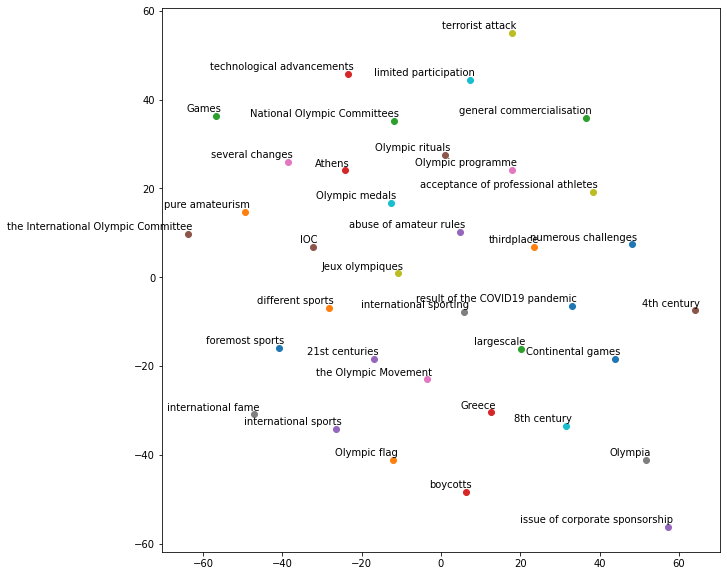

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
tokens=[]
labels=[]
x = []
y = []
for i in range(len(phrase_embeddings)):
  tokens.append(phrase_embeddings[i].tolist())
  labels.append(phrases[i])

kpca = KernelPCA(n_components = 50 , kernel = 'rbf')
tokens1 = kpca.fit_transform(tokens)

tsne_model = TSNE(perplexity=35,early_exaggeration=2.0,n_components=2, init='pca', n_iter=300, random_state=26)
new_values = tsne_model.fit_transform(tokens1)

for value in new_values:
    x.append(value[0])
    y.append(value[1])

        
plt.figure(figsize=(10, 10)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(5, 2),textcoords='offset points',ha='right', va='bottom')

plt.show()

# 5.cosine similarity

In [ ]:
from scipy.spatial.distance import cosine

selected_keyphrases=[]
similarity=[]
keyword=[]
embed=[]

for i in range(len(phrase_embeddings)):
  sim = 1 - cosine(document_embedding, phrase_embeddings[i])
  similarity.append(sim)
  keyword.append(phrases[i])
  embed.append(phrase_embeddings[i])


for i in range(len(similarity)):  
  for j in range(0, len(similarity)-i-1):  
    if similarity[j] < similarity[j+1] : 
      similarity[j], similarity[j+1] = similarity[j+1], similarity[j]
      keyword[j], keyword[j+1] = keyword[j+1], keyword[j]
      embed[j], embed[j+1] = embed[j+1], embed[j]

selected_keyphrases=keyword[0:10]
selected_keyphrases_similarity=similarity[0:10]
selected_keyphrases_embeddings=embed[0:10]

In [ ]:
for i in selected_keyphrases:
  print(i)

Olympic rituals
National Olympic Committees
the Olympic Movement
international sporting
international sports
boycotts
Continental games
the International Olympic Committee
general commercialisation
technological advancements


In [ ]:
print("no of candidate phrases: ",len(phrases))
print("no of selected phrases: ",len(selected_keyphrases))

no of candidate phrases:  36
no of selected phrases:  10
